In [2]:
#import user modules
import utils.helper_functions as hfun
import config as cf
import modules.thouless_times as thouless
import modules.spectral_functions as spec_fun
import modules.sff as sff_module
import modules.adiabatics as agp
import modules.anderson as anderson
import importlib
from utils.fit_functions import *
def reload_modules():
    importlib.reload(anderson)
    importlib.reload(hfun)
    importlib.reload(cf)
    importlib.reload(thouless)
    importlib.reload(spec_fun)
    importlib.reload(agp)
    importlib.reload(sff_module)

reload_modules()

from utils.fit_functions import *
#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter

print(cf.base_directory)
from cmath import nan
import h5py    


user_settings = getattr(cf.plot_settings, 'settings')


../results/HEISENBERG/disorder/PBC/


# XYZ TESTS

5.0
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=10,J=2.00,J0=0.50,g=0.90,g0=0.40,h=0.80,w=0.10_subsize=5_jobid=0.hdf5
Keys: <KeysViewHDF5 ['energies', 'entropy']>
6.0
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=12,J=2.00,J0=0.50,g=0.90,g0=0.40,h=0.80,w=0.10_subsize=6_jobid=0.hdf5
Keys: <KeysViewHDF5 ['energies', 'entropy']>
7.0
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=14,J=2.00,J0=0.50,g=0.90,g0=0.40,h=0.80,w=0.10_subsize=7_jobid=0.hdf5
Keys: <KeysViewHDF5 ['energies', 'entropy']>
8.0
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=16,J=2.00,J0=0.50,g=0.90,g0=0.40,h=0.80,w=0.10_subsize=8_jobid=0.hdf5
Keys: <KeysViewHDF5 ['energies', 'entropy']>
3.0
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=9,J=2.00,J0=0.50,g=0.90,g0=0.40,h=0.80,w=0.10_subsize=3_jobid=0.hdf5
Keys: <KeysViewHDF5 ['energies', 'entropy']>
4.0
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=12,J=2.00,J0=0.50,g=0.90,g0=0.40,h=0.80,w=0.10_subsize=4_jobid=0.hdf5
Keys: <KeysViewHDF5 ['energies',

Text(0.5, 0.98, 'Subsystem fraction f = 0.25')

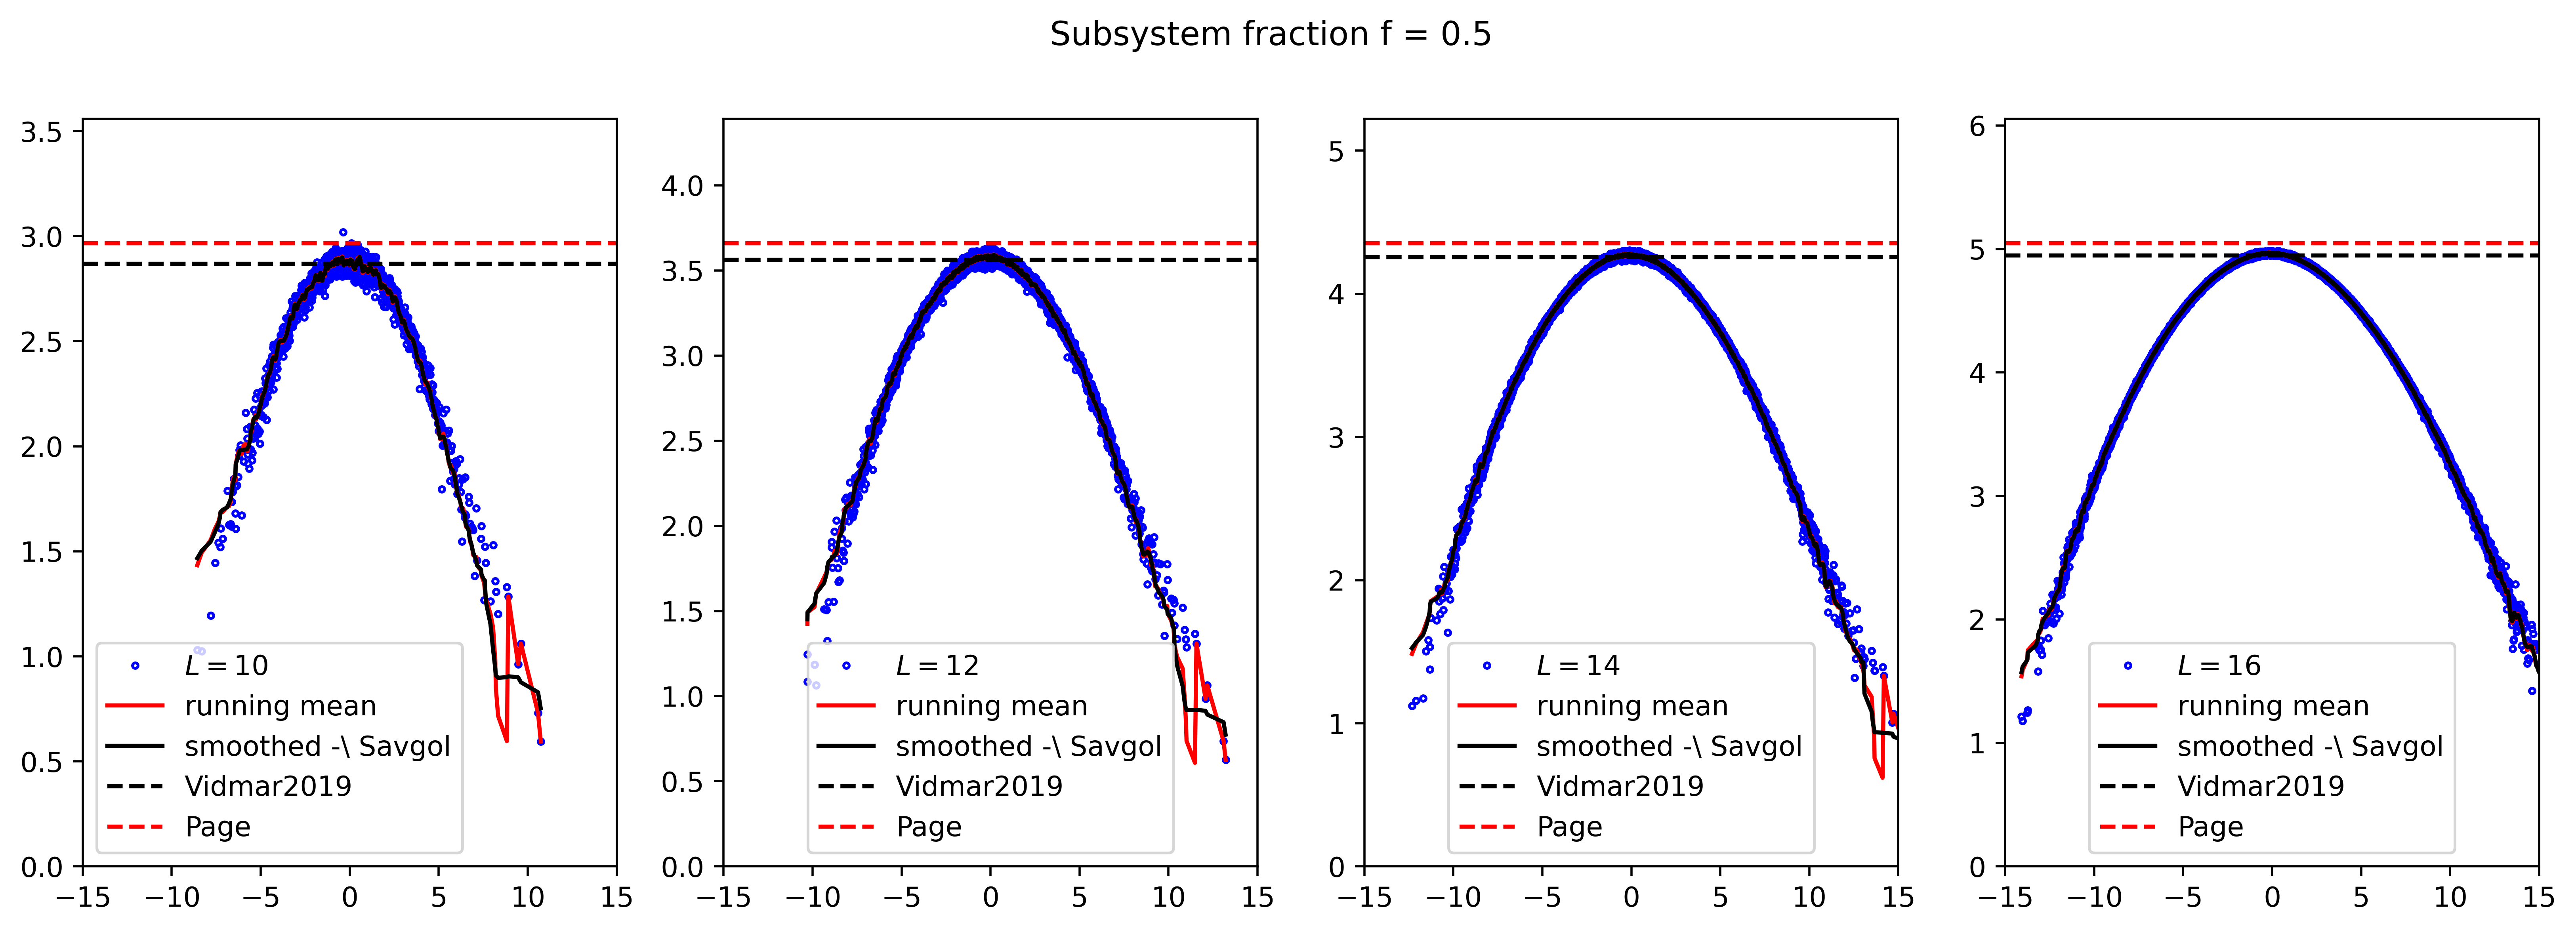

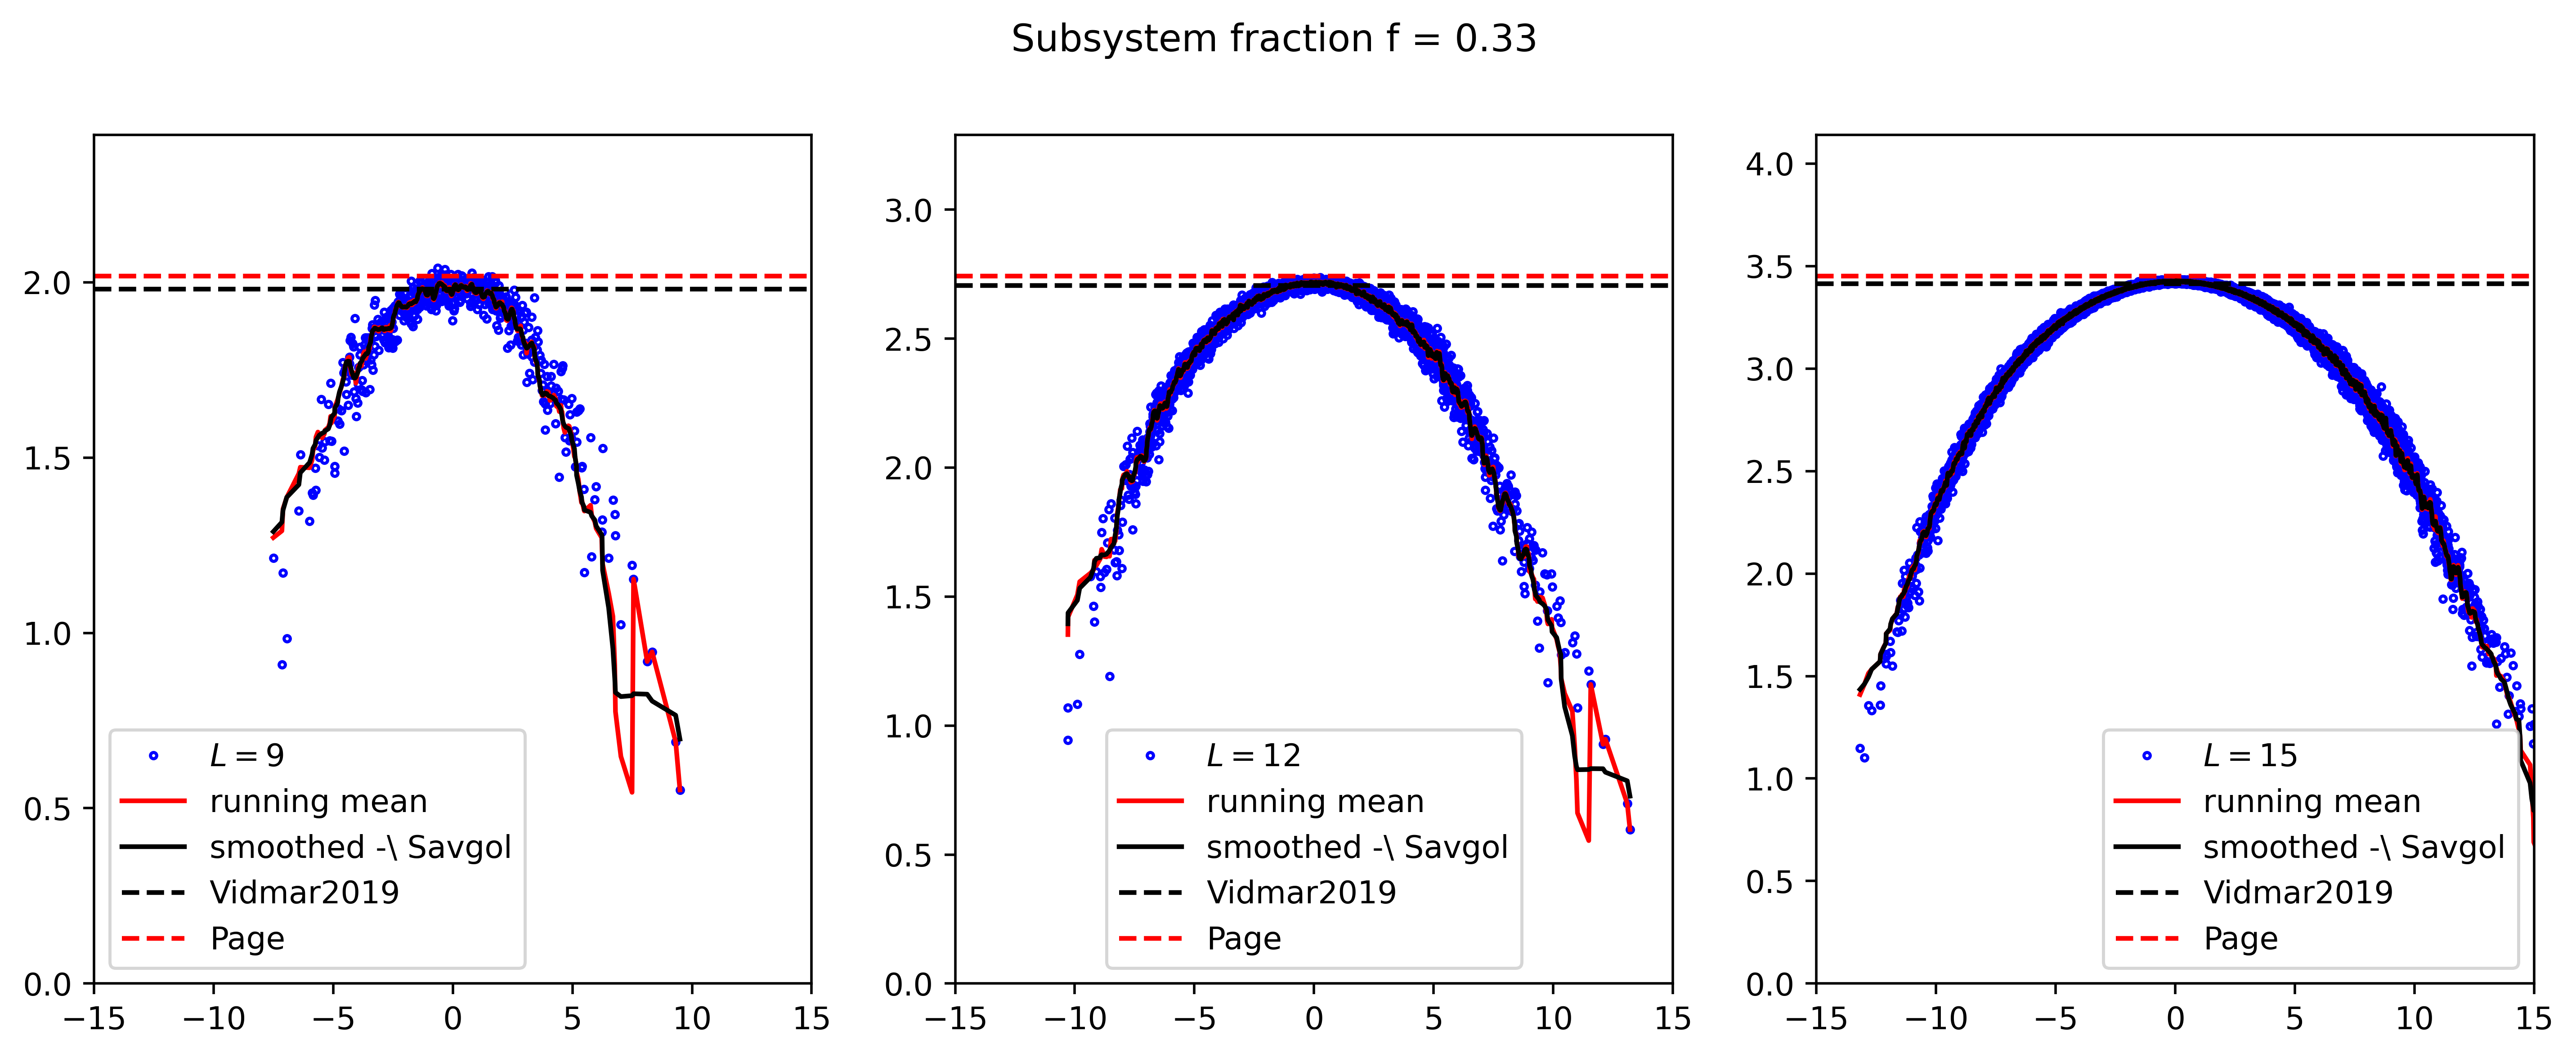

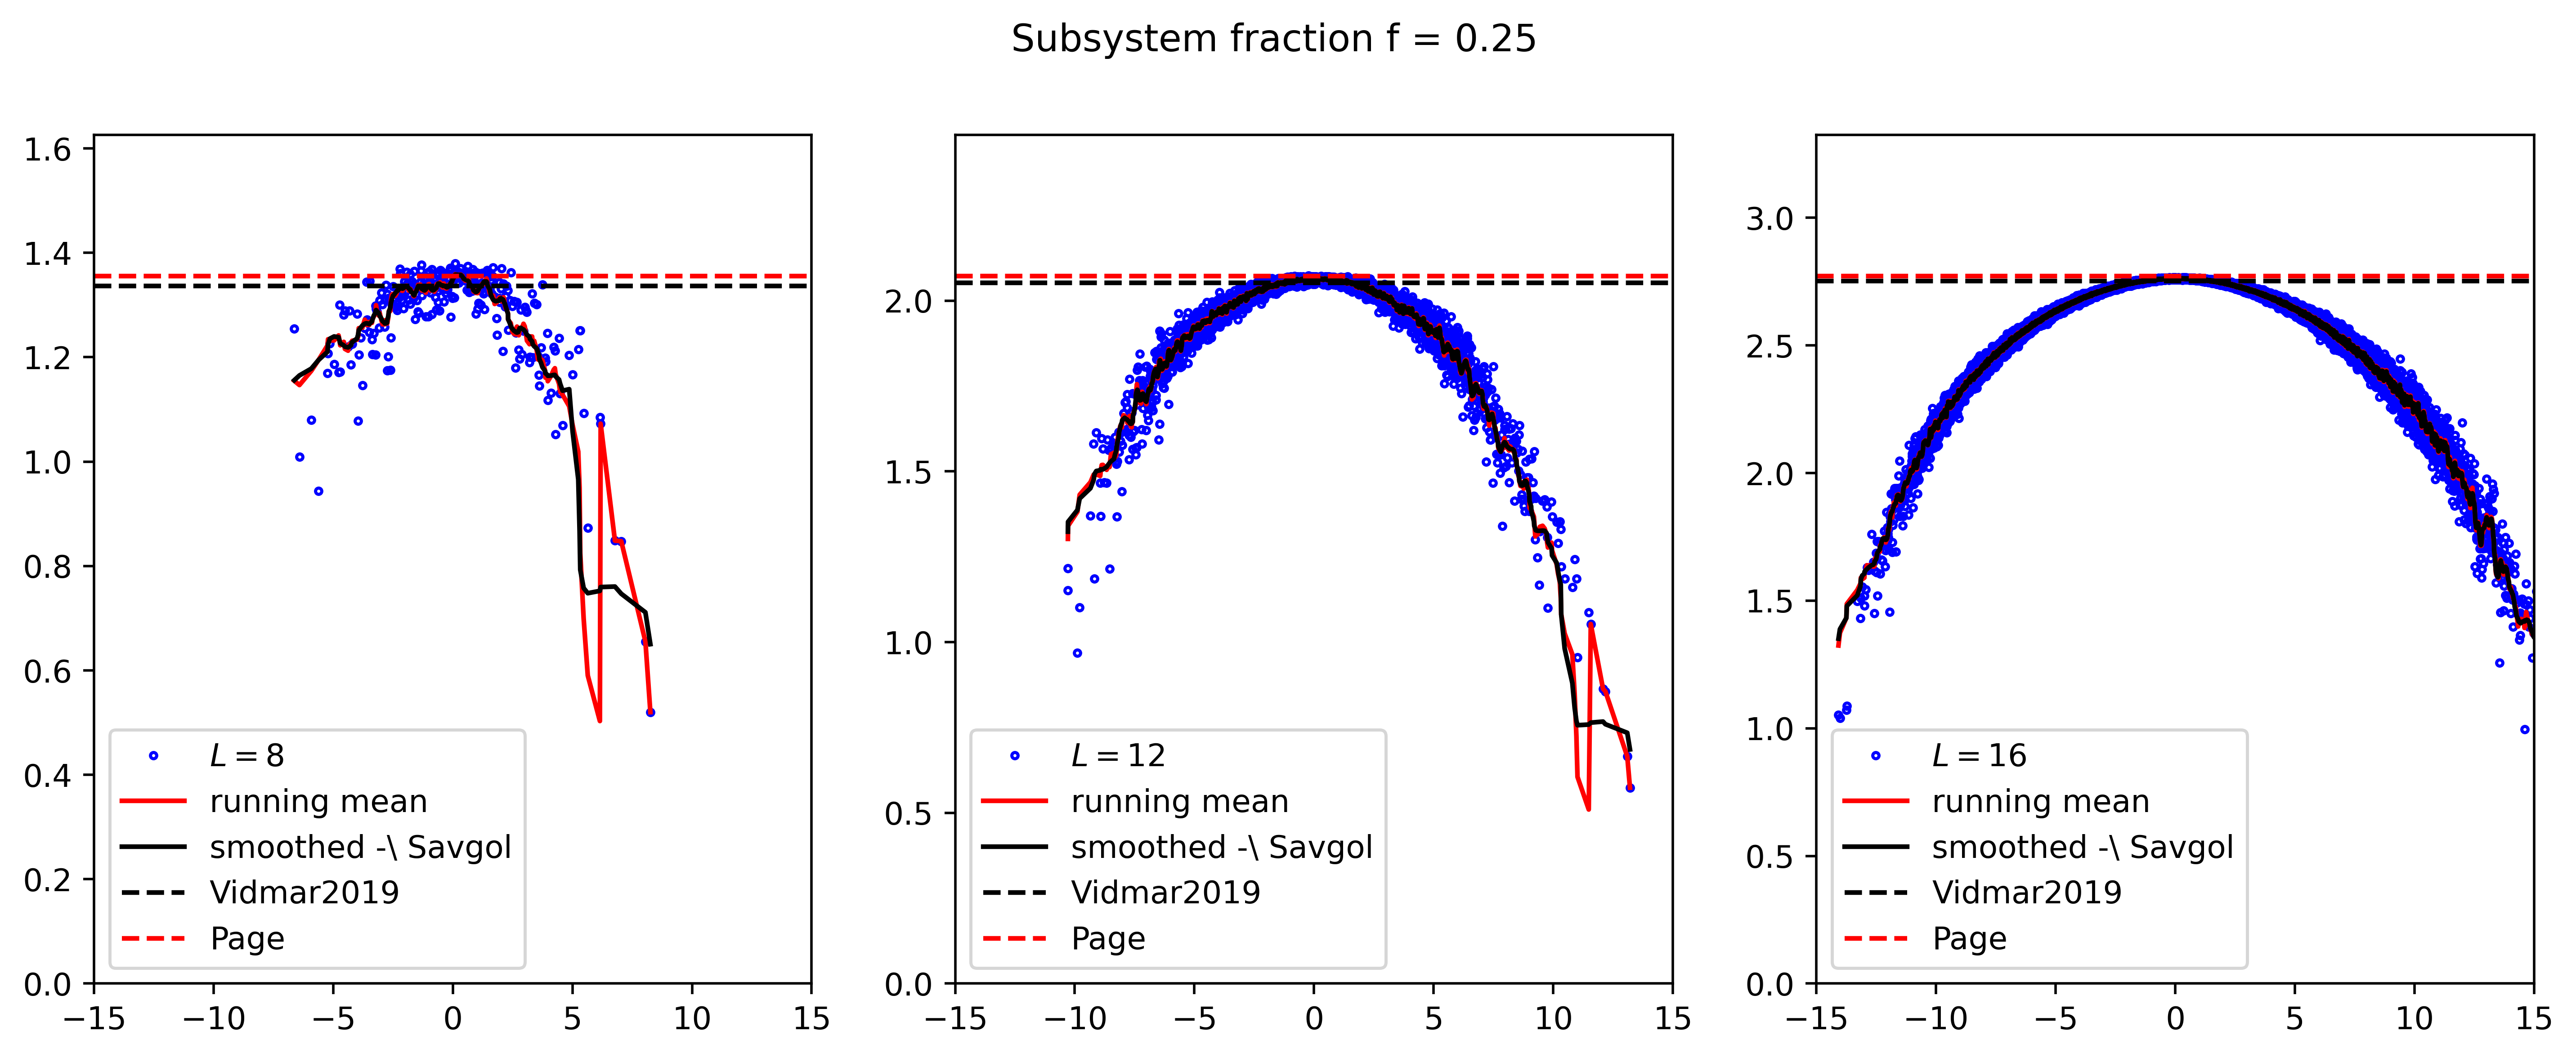

In [3]:
reload_modules()

SYMMETRIES = 0
dir = "../results/XYZ/symmetries/PBC/Entropy/Eigenstate/" if SYMMETRIES else "../results/XYZ/disorder/OBC/Entropy/Eigenstate/"
L=10
J=2.0
J0=0.5
g=0.9
g0=0.4
h=0.8
w=0.1
k=0
p=1
x=1



def page(L, f):    
    return f * L * np.log(2) - 0.5 * 2**(2 * f * L - L)
def Srand(L, f): 
    return f * L * np.log(2) + (f + np.log(1-f)) / 2. - 0.5 * 2**(2 * f * L - L)
validL = []
Smean = []
gap_ratio = []
def plot_here(axis, L, f = 0.5):
    info = hfun.info_sym(L, J, g, h, k, p, x) if SYMMETRIES else hfun.info_dis(L, J, J0, g, g0, h, w)
    info = dir + info[0 : info.index('.dat') :]
    print(f * L)
    filename = info + "_subsize=%d_jobid=0.hdf5"%(f * L)
    print(filename)
    if exists(filename):
        data = []
        with h5py.File(filename, "r") as file:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            print("Keys: %s" % file.keys())
            energies = np.array(file.get('energies')[0])
            entropy = np.array(file.get('entropy')[0])
            #eigenvectors = np.array(f.get('eigenvectors'))
        
        p = axis.plot(energies, entropy, label=r"$L=%d$"%L, marker='o', markersize=2, linewidth=0, color='blue', markerfacecolor='None')

        entropy_smoothed = hfun.remove_fluctuations(entropy, bucket_size=10)
        entropy_smoothed2 = savgol_filter(entropy, window_length=17, polyorder=5, mode="nearest")
        axis.plot(energies, entropy_smoothed, color='red',label='running mean')
        axis.plot(energies, entropy_smoothed2, color='black',label='smoothed -\ Savgol')
        
        axis.axhline(y=Srand(L=L, f=f), linestyle='--', color='black', label="Vidmar2019")
        axis.axhline(y=page(L=L, f=f), linestyle='--', color='red', label="Page")
        axis.set_ylim(0, 1.2*page(L, f))
        axis.set_xlim(-15, 15)
        axis.legend()
        


fig, ax = plt.subplots( nrows=1, ncols=4, figsize=(16,5), dpi = 500)
#plot_here(axis=ax[0], L=8, f=0.5)
plot_here(axis=ax[0], L=10, f=0.5)
plot_here(axis=ax[1], L=12, f=0.5)
plot_here(axis=ax[2], L=14, f=0.5)
plot_here(axis=ax[3], L=16, f=0.5)
fig.suptitle("Subsystem fraction f = 0.5")

fig, ax = plt.subplots( nrows=1, ncols=3, figsize=(14,5), dpi = 500)
plot_here(axis=ax[0], L=9, f=1./3.)
plot_here(axis=ax[1], L=12, f=1./3.)
plot_here(axis=ax[2], L=15, f=1./3.)
fig.suptitle("Subsystem fraction f = 0.33")

fig, ax = plt.subplots( nrows=1, ncols=3, figsize=(14,5), dpi = 500)
plot_here(axis=ax[0], L=8, f=0.25)
plot_here(axis=ax[1], L=12, f=0.25)
plot_here(axis=ax[2], L=16, f=0.25)
fig.suptitle("Subsystem fraction f = 0.25")
#plot_here(axis=ax[2], L=18)


../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=8,J=2.00,J0=0.50,g=0.90,g0=0.40,h=0.80,w=0.10_subsize=2_jobid=0.hdf5 Keys: <KeysViewHDF5 ['energies', 'entropy']>
256 82 182 132
256 82 182 132
256 86 186 136
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=12,J=2.00,J0=0.50,g=0.90,g0=0.40,h=0.80,w=0.10_subsize=3_jobid=0.hdf5 Keys: <KeysViewHDF5 ['energies', 'entropy']>
4096 2056 2156 2106
4096 2056 2156 2106
4096 2109 2209 2159
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=16,J=2.00,J0=0.50,g=0.90,g0=0.40,h=0.80,w=0.10_subsize=4_jobid=0.hdf5 Keys: <KeysViewHDF5 ['energies', 'entropy']>
65536 33486 33586 33536
65536 33486 33586 33536
65536 32893 32993 32943
[1.3591949265656795, 2.0674992431056376, 2.763167671613278]


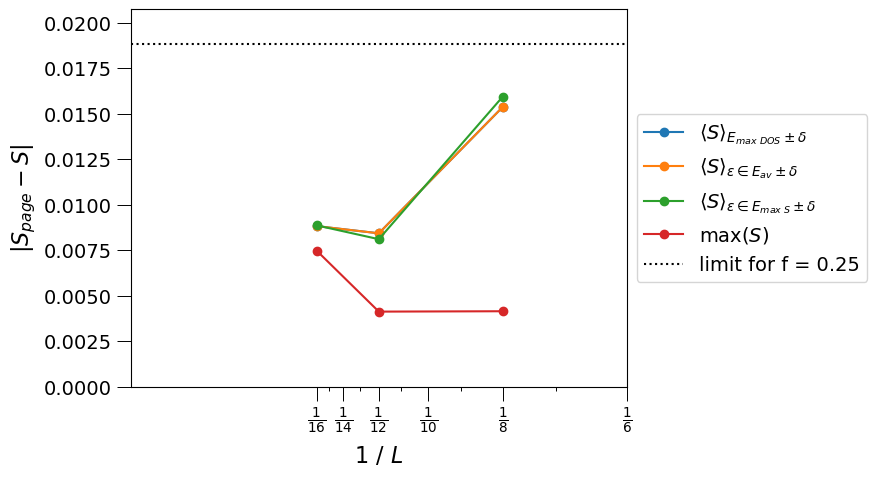

In [4]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(8,5), dpi = 100)

Smean_ener = []
S_dos = []
S_max_ent = []
validL = []
Smax = []
S_at_Eav = []

f = 1/4

for L in range(8, 17, 1):    
    info = hfun.info_sym(L, J, g, h, k, p, x) if SYMMETRIES else hfun.info_dis(L, J, J0, g, g0, h, w)
    info = dir + info[0 : info.index('.dat') :]
    
    filename = info + "_subsize=%d_jobid=0.hdf5"%(f * L)
    if exists(filename) and abs(int(f * L) - f * L) < 0.01:
        data = []
        with h5py.File(filename, "r") as file:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            print(filename, "Keys: %s" % file.keys())
            energies = np.array(file.get('energies')[0])
            entropy = np.array(file.get('entropy')[0])
        
        
        entropy_smoothed = hfun.remove_fluctuations(entropy, bucket_size=10)
        entropy_smoothed2 = savgol_filter(entropy, window_length=15, polyorder=5, mode="nearest")
        size = energies.size

        # get mean energy
        def get_S(idx):
            num = 100 if L > 8 else 100
            #num = 0.5 * size
            my_min = int(idx - num / 2);    
            if my_min < 0: my_min = 0
            my_max = int(idx + num / 2);    
            if my_max>= size: my_max = size

            print(size, my_min, my_max, idx)
            sample = entropy[my_min : my_max]
            return np.mean(sample)

        E_av = np.sum(energies) / size
        idx = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
        Smean_ener.append(get_S(idx))
        S_at_Eav.append(entropy[idx])

        E_av = np.mean(energies)
        idx = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
        S_dos.append(get_S(idx))
        
        E_av = max(entropy)
        idx = min(range(len(entropy)), key=lambda i: abs(entropy[i] - E_av))
        S_max_ent.append(get_S(idx))

        Smax.append(max(entropy))
        
        validL.append(L)

validL = np.array(validL)
def plot_with_fit(axis, sizes, entropy, label = "oh"):
    ydata = np.abs(entropy - page(L=sizes, f=f))

    p = axis.plot(1. / sizes, ydata, marker='o', label=label)
    #pars, sth = fit(f=power_law, 
    #                    xdata=1./sizes, 
    #                    ydata=ydata)
    #
    #Ls = np.linspace(0, 0.2, 100)
    #axis.plot(Ls, power_law(Ls, *pars), linestyle='--', color=p[0].get_color())

plot_with_fit(axis=ax, sizes=validL, entropy=S_dos, label=r"$\langle S \rangle_{E_{max\ DOS}\pm\delta}$")
plot_with_fit(axis=ax, sizes=validL, entropy=Smean_ener, label=r"$\langle S\rangle_{\epsilon\in E_{av}\pm\delta}$")
plot_with_fit(axis=ax, sizes=validL, entropy=S_max_ent, label=r"$\langle S\rangle_{\epsilon\in E_{max\ S}\pm\delta}$")
plot_with_fit(axis=ax, sizes=validL, entropy=Smax, label=r"$\max(S)$")
#plot_with_fit(axis=ax, sizes=validL, entropy=S_at_Eav, label=r"$S(E_{av})$")
print(Smax)
ax.axhline(y = -(f + np.log(1-f)) / 2, linestyle=':', color='black', label="limit for f = %.2f"%f)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0,0.15)
arr = [S_dos, Smean_ener, S_max_ent, Smax]
arr = [max(np.abs(page(L=(validL), f=f) - x)) for x in arr]
arr.append(-(f + np.log(1-f)) / 2)
ax.set_ylim(0, 1.1 * max(arr))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

hfun.set_plot_elements(axis = ax, ylabel = "|S_{page} - S|", xlabel = "1\ / \ L", settings=user_settings, 
                            font_size=14, set_legend=True, xlim=(None, None), ylim=(None, None))

ax.legend(frameon=True, ncol=1
                , loc='center left', bbox_to_anchor=(1, 0.5)
                , fontsize=14)
ax.set_xscale('linear');    ax.set_yscale('linear')

sizes = np.array([6, 8, 10, 12, 14, 16])
ax.set_xticks(1. / sizes)
ax.set_xticklabels([r"$\frac{1}{%d}$"%x for x in sizes])
ax.xaxis.set_minor_locator(plt.FixedLocator(1. / (sizes - 1)))

# HEISENBERG RESULTS

_L=*,J=1.00,J0=0.00,g=*,g0=0.00,h=0.00,w=0.70_subsize=*_jobid=*.hdf5
[10, 12, 14, 16, 18]
[5.8e-04 7.6e-04 8.7e-04 1.0e-03 1.1e-03 1.3e-03 1.5e-03 1.7e-03 2.0e-03
 2.3e-03 2.6e-03 3.0e-03 3.5e-03 4.0e-03 4.6e-03 5.3e-03 6.0e-03 6.9e-03
 7.9e-03 9.1e-03 1.0e-02 1.2e-02 1.4e-02 1.6e-02 1.8e-02 2.0e-02 2.1e-02
 2.4e-02 2.8e-02 3.2e-02 3.6e-02 4.0e-02 4.2e-02 4.8e-02 5.5e-02 6.0e-02
 6.3e-02 7.2e-02 8.0e-02 8.3e-02 9.6e-02 1.0e-01 1.1e-01 1.2e-01 1.3e-01
 1.4e-01 1.6e-01 1.7e-01 1.8e-01 1.9e-01 2.0e-01 2.2e-01 2.4e-01 2.5e-01
 2.6e-01 2.8e-01 2.9e-01 3.0e-01 3.2e-01 3.3e-01 3.4e-01 3.6e-01 3.8e-01
 4.0e-01 4.2e-01 4.4e-01 4.6e-01 4.8e-01 5.0e-01 5.2e-01 5.4e-01 5.5e-01
 5.6e-01 5.8e-01 6.0e-01 6.2e-01 6.4e-01 6.6e-01 6.8e-01 7.0e-01 7.2e-01
 7.4e-01 7.6e-01 7.8e-01 8.0e-01 8.2e-01 8.4e-01 8.6e-01 8.7e-01 8.8e-01
 9.0e-01 9.2e-01 9.4e-01 9.6e-01 9.8e-01 1.0e+00]
[   0    1    2    3    4    6   30   32   33   34   35   36   37   38
   39  100  200  300  400  500  600  700  800  900 1000 110

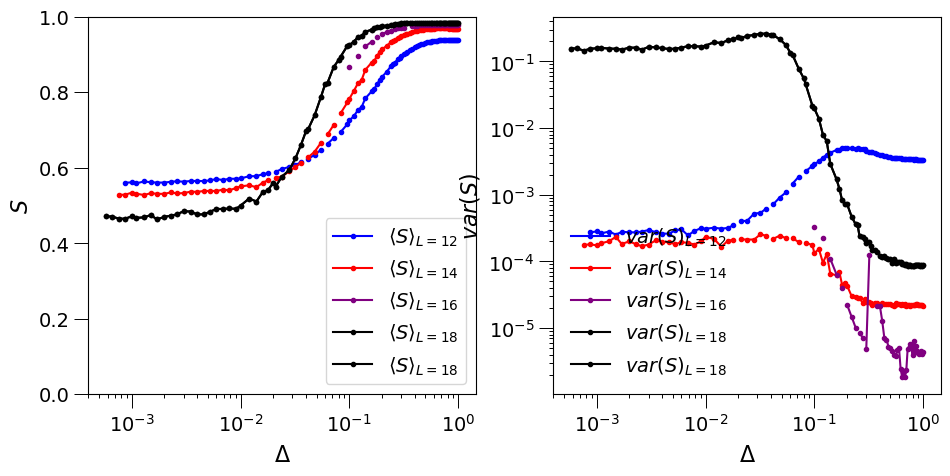

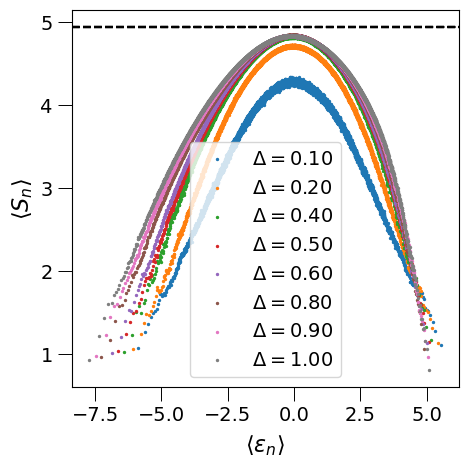

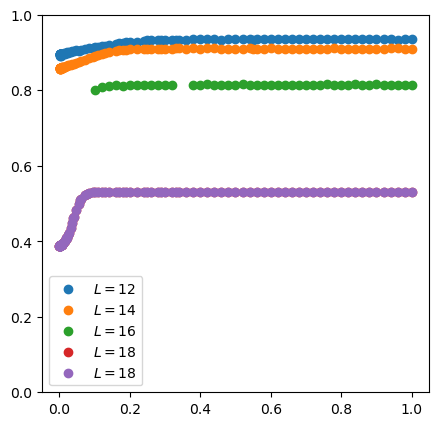

In [3]:
reload_modules()

from fnmatch import fnmatch as fn
dir_in = f"{cf.base_directory}Entropy{os.sep}Eigenstate{os.sep}raw_data{os.sep}"
dir_out = f"{cf.base_directory}Entropy{os.sep}Eigenstate{os.sep}"


set_class = copy.deepcopy(cf.plot_settings)
set_class.set_scaling('g')
set_class.set_vs('x')
settings = getattr(set_class, 'settings')

SINGLE_REALISATION = 0

ii = settings['scaling_idx']
info = ""
# ASSUMING DISORDER MODULE FOR NOW
arr = [cf.J, cf.J0, cf.g, cf.g0, cf.h, cf.w]
names = ['J', 'J0', 'g', 'g0', 'h', 'w']
indices = [-1, 0, 2, 4, 5]
def create_info(use_log_data = True):
    info = "_L=*"
    for i, var in enumerate(arr):
        n = hfun.order_of_magnitude(var) if use_log_data else 2
        if i == indices[ii]:
            info += ",%s=*"%names[i]
        else: info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info + "_subsize=*_jobid=*.hdf5"
info = create_info()
print(info)

sizes = []
collected_pars = []
realis = []
#--------------------------------------- COLLECT DATA
def append_parameter_range(filename):
    if fn(filename, info):
        bare_info, extension = os.path.splitext(filename)
        
        f = os.path.join(dir_in, filename)
        if os.path.isfile(f):
            pars = hfun.get_params_from_info(bare_info)
            
            if pars[ii] not in collected_pars:  collected_pars.append(pars[ii])
            if pars[0] not in sizes:            sizes.append(int(pars[0]))
            if pars[-1] not in realis:          realis.append(int(pars[-1]))

for filename in os.listdir(dir_in): 
    info = create_info()
    append_parameter_range(filename)
    info = create_info(False)
    append_parameter_range(filename)

pars = cf.params_arr
sizes = list(np.sort(sizes))
collected_pars = np.sort(collected_pars)
realis = np.sort(realis)
print(sizes)
print(collected_pars)
print(realis)
lab = hfun.var_name if settings['scaling_idx'] == 2 else settings['scaling']
vals = hfun.get_scaling_array(settings, x0=0.1, xend=1.0, dx=0.1)

sizes = sizes if ii != 0 else [0];
entropy = []
colors = {
    10: 'green',
    12: 'blue', 
    14: 'red',
    16: 'purple', 
    18: 'black'
    }
fig, (ax, axis) = plt.subplots( nrows=1, ncols=2, figsize=(11,5), dpi = 100)
fig, ax2 = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
fig, ax3 = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)


param_copy = copy.deepcopy(cf.params_arr)
sizes.append(18);   sizes = np.array(sizes)

for L in sizes[1:]:
    new_pars = pars
    if ii != 0:
        new_pars[0] = L

    info_out = dir_out + hfun.remove_info(hfun.info_param(new_pars), settings['scaling']) + "_subsize=%d.hdf5"%(L/2)
    S = []
    i = 0
    Smax = []
    Svar = []

    x = []
    gaps = []
    if L == 18:
        cf.params_arr[settings['scaling_idx']] = L
        filename = cf.base_directory + "STATISTICS" + os.sep + hfun.remove_info(hfun.info_param(cf.params_arr), settings['scaling']) + ".dat" 
        if os.path.exists(filename):
            stats = hfun.read_python_saved_dat_file(filename)
            
            x = stats[0]
            gaps = stats[1]
            S = stats[4]
            Smax = [np.nan for i in range(x.size)]
            Svar = stats[7]
    else:
        x = collected_pars

        for par in collected_pars:
            new_pars[ii] = par
            info_in = hfun.info_param(new_pars)
            base_info, ext = os.path.splitext(info_in)

            info_in = base_info + "_subsize=%d"%(L/2) + "_jobid=%d.hdf5"%realis[0]
            if SINGLE_REALISATION:
                info_in = "realisation=%d"%0 + os.sep + base_info + "_subsize=%d"%(L/2) + ".hdf5"
            ener = [0 for i in range(int(binom(L, int(L/2))))]
            ent = [0 for i in range( int(binom(L, int(L/2))))]
            counter = 0.0
            Sall = []
            rall = 0
            for r in (realis  if SINGLE_REALISATION == 0 else [0]):
                info_in = base_info + "_subsize=%d"%(L/2) + "_jobid=%d.hdf5"%r
                if os.path.exists(dir_in + info_in):
                    with h5py.File(dir_in + info_in, "r") as f:
                        # Print all root level object names (aka keys) 
                        # these can be group or dataset names
                        E = np.array(f.get('energies')[0])
                        ener += E
                        ent += np.array(f.get('entropy')[0])
                        counter += 1.0
                        r=0;
                        cunt = 0
                        for i in range(E.size):
                            if i > int(0.25 * E.size) and i < int(0.75 * E.size):
                                gap1 = E[i] - E[i - 1];
                                gap2 = E[i + 1] - E[i];
                                if gap1 <= 1e-15:
                                    print("Degeneracy", E[i-5 : i+5])
                                r += min(gap1, gap2) / max(gap1, gap2)
                                cunt += 1.0
                        r /= cunt
                        rall += r
            if counter > 0:
                gaps.append(rall / counter)
            else:
                gaps.append(np.nan)

            ener = np.array(ener) / counter
            ent = np.array(ent) / counter



            if par in vals and L == 16 and max(ent) > 1e-2:
                norm = L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5
                ax2.axhline(y=norm, linestyle='--', color='black')
                ax2.scatter(ener, ent, label=r"$%s=%.2f$"%(lab, par), s=2)

            idx_min = int(0.5 * ent.size) - 250
            idx_max = int(0.5 * ent.size) + 250  
            ent = ent[idx_min : idx_max]
            S.append(np.mean(ent))
            Smax.append(max(ent))
            Svar.append(np.var(ent))

    Smax = np.array(Smax)        
    norm = L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5 
    ax.plot(x, S / norm, label=r"$\langle S\rangle_{L=%d}$"%L, marker = 'o', markersize=3, color=colors[L])
    #ax.scatter(x, Smax / norm, marker='s', edgecolor=colors[L], facecolor='None', label=r"$S^{max}_{L=%d}$"%L,s=8)  
    ax3.scatter(x, gaps, label=r"$L=%d$"%L)
    ax3.set_ylim(0., 1.)
    axis.plot(x, Svar, marker = 'o', markersize=3, color=colors[L], label=r"$var(S)_{L=%d}$"%L)    

    entropy.append(np.array(S))  

cf.params_arr = param_copy
hfun.set_plot_elements(axis = ax, ylabel = "S", xlabel = lab, settings=settings, 
                            font_size=14, set_legend=True, xlim=(None, None), ylim=(None, None))
hfun.set_plot_elements(axis = axis, ylabel = "var(S)", xlabel = lab, settings=settings, 
                            font_size=14, set_legend=True, xlim=(None, None), ylim=(None, None))

ax.legend(frameon=True, ncol=1
                , loc='best'
                , fontsize=14)
ax.set_xscale('log');    ax.set_yscale('linear')
ax.set_ylim(0,1)
hfun.set_plot_elements(axis = ax2, xlabel = "\\langle \\epsilon_n\\rangle", ylabel = "\\langle S_n\\rangle", settings=settings, 
                            font_size=14, set_legend=False, xlim=(None, None), ylim=(None, None))
ax2.legend(frameon=True, ncol=1
                , loc='best'
                , fontsize=14)
ax2.set_xscale('linear');    ax2.set_yscale('linear')
fig.subplots_adjust(wspace=0.4, hspace=0.2)

ax3.legend()
